In [1]:
import autoreload
%load_ext autoreload
%autoreload 2

In [2]:
import sys
#sys.path.append('/home/cjw/Code/xlearn')

In [3]:
import tifffile
import torch
from matplotlib import pyplot as plt
import numpy as np
import scipy.ndimage as ndi
from skimage.color import label2rgb
from skimage.transform import downscale_local_mean
## stuff from xlearn
import cell_length
import infer
import train
from tqdm import tqdm_notebook
import pandas as pd
import seaborn as sns
%matplotlib inline

In [4]:
is_inferring = True
is_calc_length = True

In [24]:
if is_inferring:
    tm = train.get_model(2)
    tm.load_state_dict(torch.load("Data/Sas/trained_model.pt"))

IFM 256


In [40]:
import glob
#filename = '/n/core/micro/jeg/ac1692/cjw/Movie/3-17-20_WT-Agar-ON_for_movie.tif'
sfiles = glob.glob('Data/Sas/Data/*czi*')
filename=sfiles[5]
#filename = '../3-17-20_WT-Agar-ON_bestz_transmitted.tif'
z = tifffile.imread(filename)

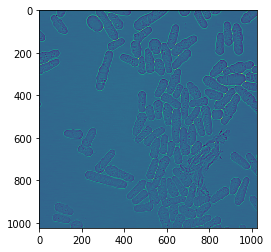

In [41]:
plt.imshow(z)

In [42]:
if is_inferring:
    if torch.cuda.is_available():
        device = torch.device('cuda')
    else:
        device = torch.device('cpu')

In [43]:
if is_inferring:
    p_z = np.zeros(z.shape, dtype=np.float32)
    cnn = infer.predict(tm, size=(512, 512), probability=.95)

    torch.cuda.empty_cache()
    r, b = cnn(z)
    p_z = r
else:
    p_z = tifffile.imread('Data/inferred.tif')

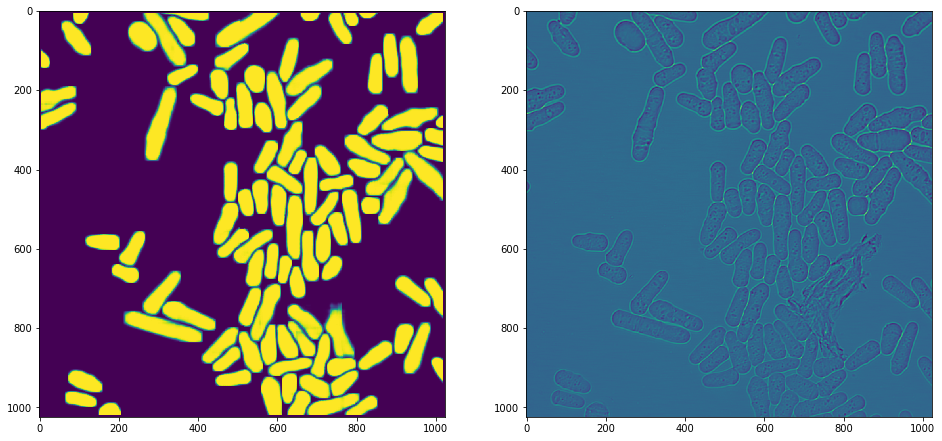

In [46]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.imshow(r)
plt.subplot(1,2,2)
plt.imshow(z)

In [ ]:
def rgbimage(stack):
    nx = stack.shape[-1]
    ny = stack.shape[-2]
    rgb = np.zeros((3, ny, nx), dtype=np.float32)
    smin = stack.min(axis=(-2, -1), keepdims=True)
    smax = stack.max(axis=(-2, -1), keepdims=True)
    nstack = (stack - smin)/(smax - smin)
    rgb[0] = nstack[0] + nstack[2]
    rgb[1] = nstack[1] + nstack[2]
    rgb[2] = nstack[0] + nstack[2]
    rgb = np.clip(rgb, 0, 1)
    rgb = np.moveaxis(rgb, 0, -1)
    
    return (255*rgb).astype(np.uint32)
    

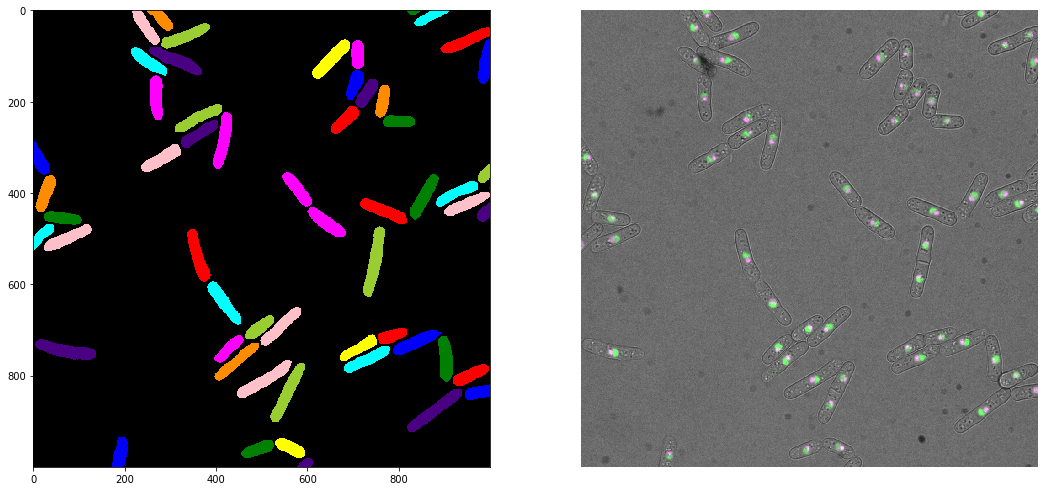

In [297]:

px = label2rgb(ndi.label(p_movie[30] > .85)[0], bg_label=0)
px=px[500:1500, 500:1500]
px2 = rgbimage(movie[30])
px2 = px2[500:1500, 500:1500]
plt.figure(figsize=(18, 9))
plt.subplot(1,2,1)
#plt.axis('off')
plt.imshow(px)
plt.subplot(1,2,2)
plt.axis('off')
plt.imshow(px2)
plt.savefig("Data/Figs/seg30.pdf")

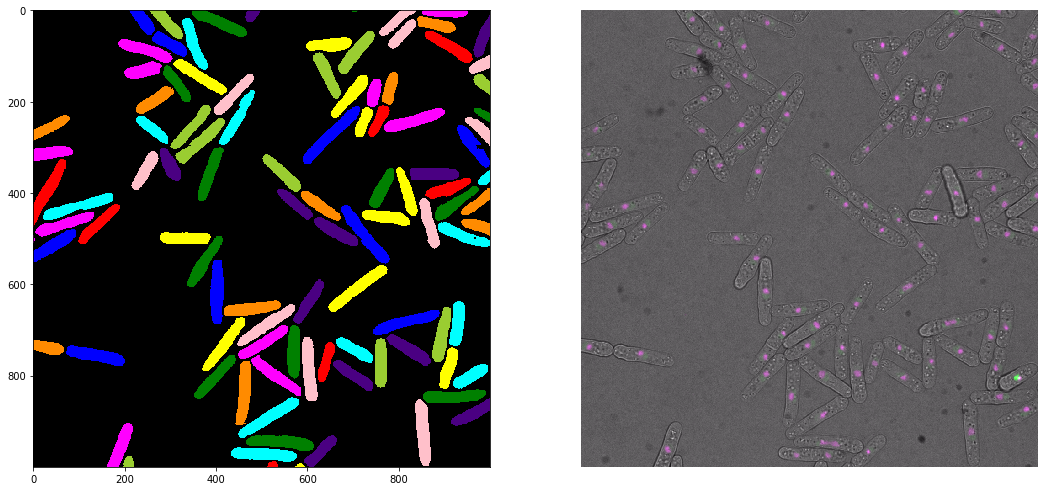

In [298]:
px = label2rgb(ndi.label(p_movie[60] > .85)[0], bg_label=0)
px=px[500:1500, 500:1500]
px2 = rgbimage(movie[60])
px2 = px2[500:1500, 500:1500]
plt.figure(figsize=(18, 9))
plt.subplot(1,2,1)
#plt.axis('off')
plt.imshow(px)
plt.subplot(1,2,2)
plt.axis('off')
plt.imshow(px2)
plt.savefig("Data/Figs/seg60.pdf")

In [ ]:

px = label2rgb(ndi.label(p_movie[72] > .85)[0], bg_label=0)
px2 = label2rgb(ndi.label((p_movie[73] > .85))[0], bg_label=0)
plt.figure(figsize=(9,18))
plt.subplot(1,1,1)
plt.imshow(px)
plt.subplot(2,1,2)
plt.imshow(px2)

In [156]:
#frame = 45
thresh = 0.85

if is_calc_length:
    dflist = list()
    erx = "clean"
    for frame in tqdm_notebook(range(p_movie.shape[0]), desc='frame'):
        labels, nlabels = ndi.label(p_movie[frame] > thresh)
        for i in tqdm_notebook(range(1, nlabels + 1),
                               desc='{} label {}'.format(frame, erx), leave=False):
            lengths = list()
            xdiff = list()
            ydiff = list()
            mx = np.where(labels == i)
            cmx = mx[1].mean()
            cmy = mx[0].mean()
            area = len(mx[0])
            try:
                length_dict = cell_length.calc_cell_length(mx)
                lengths.append(length_dict['length'])
                dux = length_dict['Xp'].max() - length_dict['Xp'].min()
                duy = length_dict['yp'].max() - length_dict['yp'].min()

                xdiff.append(dux)
                ydiff.append(duy)
                _df = pd.DataFrame({'length':lengths,
                                    'xdiff':xdiff,
                                    'ydiff':ydiff,
                                    'cmx':cmx,
                                    'cmy':cmy,
                                    'area':area,
                                    'e0':length_dict['eigenvec'][0],
                                    'e1':length_dict['eigenvec'][1],
                                    })
                _df['frame'] = frame
                _df['label'] = i
                dflist.append(_df)
            except:
                erx = "err in i"
                continue

    df = pd.concat(dflist)
else:
    df = pd.read_pickle('Data/cell_length_df.pkl')

/home/cjw/anaconda3/envs/deep/lib/python3.6/site-packages/numpy/lib/polynomial.py:630: RuntimeWarning: invalid value encountered in true_divide
  lhs /= scale


In [157]:
#df = pd.read_pickle('Data/cell_length_df.pkl')
df.to_pickle('Data/cell_length_df.pkl')

In [158]:
fmean = df.groupby('frame').agg('mean')

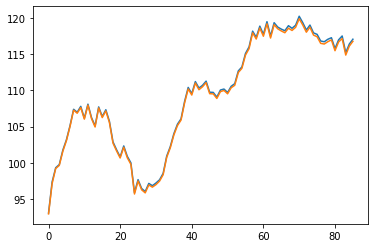

In [159]:
plt.plot(fmean.length)
plt.plot(fmean.xdiff)

In [160]:
df = df.reset_index()
df.head()

index      length       xdiff      ydiff          cmx         cmy  area  \
0      0   44.753736   44.275445  14.727618  1938.694872    8.879487   390   
1      0   91.740987   91.713713  28.699784   862.514081   49.617345  2237   
2      0  123.959378  123.661699  29.582288  1181.362488   85.724975  3007   
3      0   91.366912   91.230619  27.563816   767.789972   75.461211  2114   
4      0  115.032768  114.973349  28.151292  1403.375762  108.200789  2789   

         e0        e1  frame  label  
0  0.991321  0.131460      0      1  
1  0.751631 -0.659583      0      2  
2  0.761693  0.647938      0      3  
3  0.880561  0.473933      0      4  
4  0.990003  0.141045      0      5

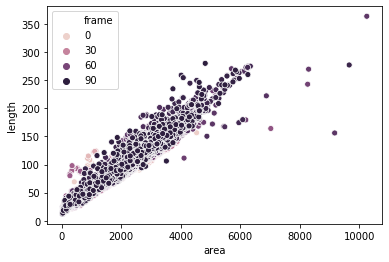

In [161]:
sns.scatterplot(x='area', y='length', hue='frame', data=df)

In [60]:
### find the ones longer than 150

longdf = df[df.length > 150]
nc1 = 47
dxy = 100
print(longdf.iloc[nc1])
cx = int(longdf.iloc[nc1].cmx)
cy = int(longdf.iloc[nc1].cmy)
frame = int(longdf.iloc[nc1].frame)
pc1 = movie[frame,:,cy-dxy:cy+dxy, cx-dxy:cx+dxy]
angle = (180/np.pi)*np.arctan2(longdf.iloc[nc1].e1, longdf.iloc[nc1].e0)
print(angle)

ppx = int(longdf.iloc[nc1].xdiff + 2)//2
ppy = max(int(longdf.iloc[nc1].ydiff + 2)//2, 10)
print(ppx, ppy)
pcr = ndi.rotate(pc1, -angle, (-2, -1), reshape=False, mode='reflect')

pp = pcr[:, 100-ppy:100+ppy, 100-ppx:100+ppx].sum(axis=0)
pprgb = rgbimage(pcr)
plotx = np.arange(len(pp[0])) - len(pp[0])//2 + 100

_, ax = plt.subplots(1, figsize=(4,4))
ax.imshow(pprgb)

_ = ax.plot(plotx, 100 - 100*(ppg-ppg.min())/(ppg.max()-ppg.min()), c='w')
_ = ax.plot(plotx, 100 - 100*(ppr-ppr.min())/(ppr.max() - ppr.min()), c='magenta')
#plt.xlim((0,200))
#_ = plt.plot((ppt-ppt.min())/(ppt.max() - ppt.min()))
print(ppg.shape)

index        0.000000
length     155.046364
xdiff      154.511063
ydiff        6.922052
cmx       1199.611774
cmy         87.514263
area      3856.000000
e0           0.739625
e1           0.673020
frame       13.000000
label        4.000000
Name: 1370, dtype: float64
42.3005497353288
78 10


ValueError: zero-size array to reduction operation minimum which has no identity

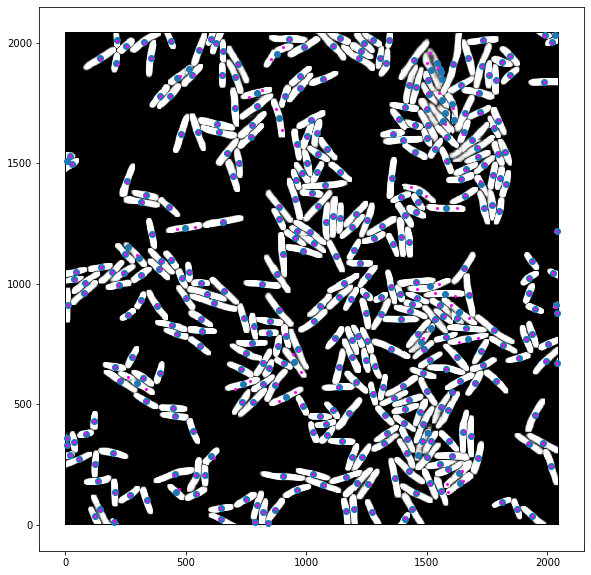

In [163]:
plt.figure(figsize=(10,10))
plt.imshow(p_movie[72], origin='bottom', cmap='gray')
dfx = df[df.frame == 72]
dfx2 = df[df.frame == 73]
plt.scatter(dfx.cmx, dfx.cmy)
#plt.scatter(dfx2.iloc[61].cmx, dfx2.iloc[61].cmy, s=40, c= 'orange')
plt.scatter(dfx2.cmx, dfx2.cmy, s=4, c='magenta')

In [164]:
from scipy.spatial.distance import pdist, cdist

def linkframes(df, f1, f2, col='frame', dmax=10.):
    d1 = df[df.loc[:,col] == f1]
    d2 = df[df.loc[:,col] == f2]
    xa = np.array([d1.cmx, d1.cmy]).T
    xb = np.array([d2.cmx, d2.cmy]).T
    dmx = cdist(xa, xb)
    
    amins = dmx.argmin(axis=1)
    rmins = dmx.min(axis=1)
    
    w1= np.where(rmins < dmax)[0]
    w2 = amins[w1]
    i1 = d1.iloc[w1].reset_index()
    i2 = d2.iloc[w2].reset_index()
    
    resdf = pd.DataFrame({'index1':d1.index[w1], 'index2':d2.index[w2]})
    return resdf

In [165]:

linklist = list()
for i in range(df.frame.max() - 1):
    linklist.append(linkframes(df, i, i + 1))
    
linkdf = pd.concat(linklist)
linkdf.shape

(19361, 2)

In [166]:
x1 = linkdf.index1.to_numpy()
x2 = linkdf.index2.to_numpy()    
print(len(x1), len(x2))
xlist = [x1, x2]
celldict = dict()
idinc = 0
while len(x1) > 0:
    found = True
    clist = [x1[0], x2[0]]
    x1 = np.delete(x1, 0)
    x2 = np.delete(x2, 0)
    while found:
        res = np.where(x1 == clist[-1])
        if len(res[0]) == 0:
            found = False
            continue
        res = res[0][0]
        clist.append(x2[res])
        x1 = np.delete(x1, res)
        x2 = np.delete(x2, res)
    celldict[idinc] = clist
    idinc += 1
    #print(len(x1), len(clist))
    #print(len(celldict))
print(len(celldict))

# plt.imshow(p_movie[36, 0:100, 1900:2000], origin='bottom')
# plt.plot(df.iloc[clist].cmx - 1900, df.iloc[clist].cmy)

19361 19361
1117


In [167]:
df['keyed'] = False
for k in celldict.keys():
    df.loc[celldict[k], 'cellid'] = k
    df.loc[celldict[k], 'keyed'] = True

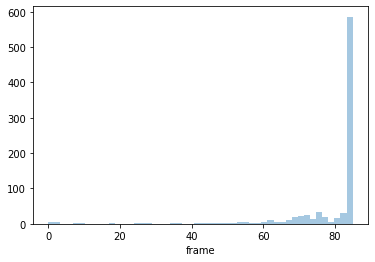

In [168]:
sns.distplot(df[df.keyed == False].frame, kde=False)

(3, 240, 240) slice(783, 1023, 1) slice(968, 1208, 1)


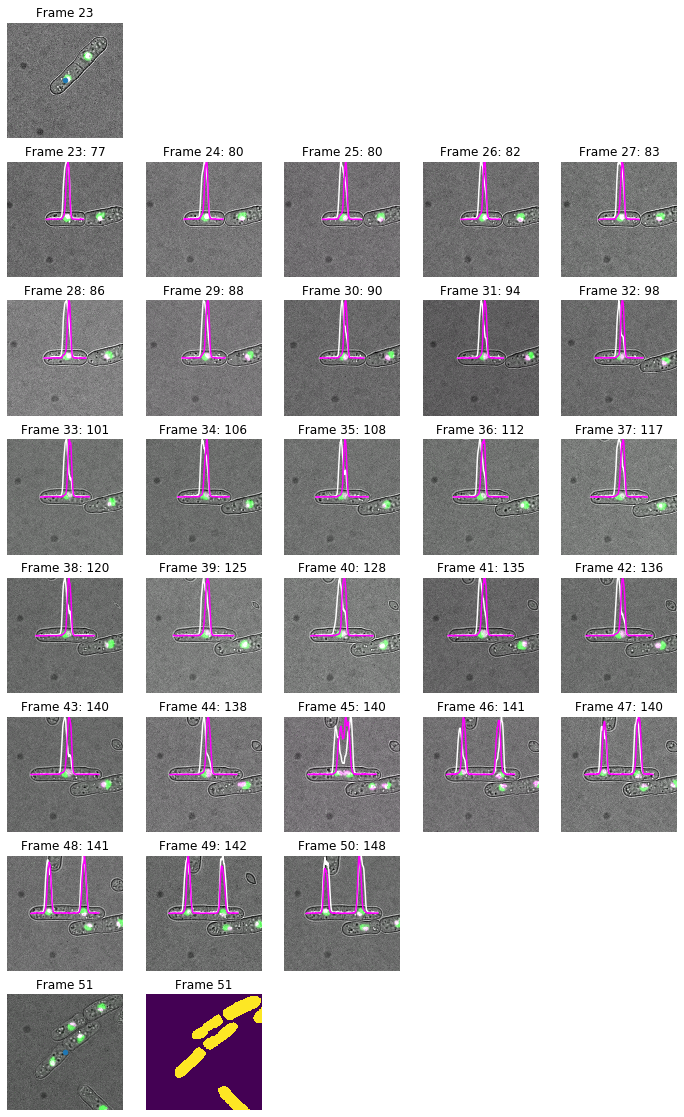

In [316]:
cid = 202
tmp = df[(df.cellid == cid) & df.keyed == True].reset_index()

dx = 120

ny = len(tmp)//5 + 3

#print(tmp)
#print(tmp.iloc[0])
m0 = tmp.iloc[0]
if m0.cmx > dx and m0.cmy > dx:
    noskip = True
    plt.figure(figsize=(12,2.5*ny))
else:
    noskip = False

if m0.frame > 0 and noskip:
    xt = int(m0.cmx)
    yt = int(m0.cmy)
    sy = slice(yt-dx, yt+dx, 1)
    sx = slice(xt-dx, xt+dx, 1)
    plt.subplot(ny,5, 1)
    print(movie[m0.frame, :, sy, sx].shape, sy, sx)
    mrgb = rgbimage(movie[m0.frame -1,  : , sy, sx])
    plt.imshow(mrgb, origin='bottom')
    plt.scatter([dx], [dx], s=20)
    plt.title(f"Frame {m0.frame}")
    plt.axis('off')

if noskip:
    for j, m in enumerate(tmp.itertuples()):
        i = m.frame
        #print(i)
        #try:
        if m.cmx < dx or m.cmy < dx:
            break
        if 2048 - m.cmx  < dx or 2044 - m.cmy < dx:
            break
        xt = int(m.cmx)
        yt = int(m.cmy)
    #     except:
    #         print(m)
    #         continue
        sy = slice(yt-dx, yt+dx, 1)
        sx = slice(xt-dx, xt+dx, 1)
        plt.subplot(ny,5, 5 + j + 1)
        angle = (180/np.pi)*np.arctan2(m.e1, m.e0)
        mrgb = rgbimage(movie[i,  : , sy, sx])

        mrgb = ndi.rotate(mrgb, -angle, (0, 1), reshape=False, mode='reflect')
        mrgb = np.clip(mrgb, 0, 255)

        ppx = int(m.xdiff + 2)//2
        ppy = 8 #max(m.ydiff, 5)
        pp = movie[i, : , sy, sx]  #[:, 100-ppy:100+ppy, 100-ppx:100+ppx].sum(axis=1)
        pp = ndi.rotate(pp, -angle, (-2, -1), reshape=False, mode='reflect')
        pp = pp[:, dx-ppy:dx+ppy, dx-ppx:dx+ppx].sum(axis=1)
        ppg = pp[1]
        ppr = pp[0]
        plotx = np.arange(len(pp[0])) - len(pp[0])//2 + dx

        plt.imshow(mrgb) #, origin='bottom')
        _ = plt.plot(plotx, dx - dx*(ppg-ppg.min())/(ppg.max()-ppg.min()), c='w')
        _ = plt.plot(plotx, dx - dx*(ppr-ppr.min())/(ppr.max() - ppr.min()), c='magenta')
        plt.title(f"Frame {i}: {int(m.length)}")
        plt.axis('off')
        #plt.scatter(100, 100, s=30, c='r', alpha=0.5)


    sy = slice(yt-dx, yt+dx, 1)
    sx = slice(xt-dx, xt+dx, 1)
    plt.subplot(ny,5, (ny - 1)*5 + 1)
    mrgb = rgbimage(movie[i + 1,  : , sy, sx])
    _ = plt.imshow(mrgb, origin='bottom')
    plt.scatter([dx], [dx], s=20)
    plt.title(f"Frame {i + 1}")
    plt.axis('off')
    
    plt.subplot(ny,5, (ny - 1)*5 + 2)
    #mrgb = rgbimage(movie[i + 1,  : , sy, sx])
    _ = plt.imshow(p_movie[i+1, sy, sx] > .85, origin='bottom')
    #plt.scatter([dx], [dx], s=20)
    plt.title(f"Frame {i + 1}")
    plt.axis('off')
    plt.savefig(f"Data/Figs/cell_frames_{cid}.pdf")
else:
    print("close to edge")
#plt.scatter(100, 100, s=50, c='r')


In [170]:
import seaborn as sns
zdf = df[df.length > 45]
start_frame = zdf.groupby('cellid').agg('min').frame.reset_index()
start_frame.columns = ['cellid', 'start_frame']
sdf = zdf.merge(start_frame, how='left', on=('cellid'))
sdf['rel_frame'] = sdf.frame - sdf.start_frame
#sns.barplot(x='frame', y='length', data=df)

In [171]:
end_frame = sdf.groupby('cellid').agg('max')[['rel_frame', 'frame']].reset_index()
end_frame.columns = ['cellid', 'end_frame', 'last_frame']
sdf = sdf.merge(end_frame, how='left', on=('cellid'))
#print(sdf.head())
sdf['track_length'] = sdf.end_frame - sdf.start_frame
#sdf['rel_frame'] = sdf.frame - sdf.start_frame
#sdf = sdf.merge(end_frame, how='left', on=('cellid'))
sdf

index      length       xdiff      ydiff          cmx          cmy  \
0          0   91.740987   91.713713  28.699784   862.514081    49.617345   
1          0  123.959378  123.661699  29.582288  1181.362488    85.724975   
2          0   91.366912   91.230619  27.563816   767.789972    75.461211   
3          0  115.032768  114.973349  28.151292  1403.375762   108.200789   
4          0  108.409578  108.329556  26.589661   201.825827   135.449183   
...      ...         ...         ...        ...          ...          ...   
20615      0   46.373782   43.410610  24.004102   659.364125  2019.816327   
20616      0  100.484253   96.799812  34.507805  1621.378151  2028.581809   
20617      0  115.291997  114.550441  25.491184   361.940590  2027.594536   
20618      0   87.277467   87.215182  20.560549  2006.857354  2031.072432   
20619      0  115.962951  115.744455  20.016909   871.548822  2032.890572   

       area        e0        e1  frame  label  keyed  cellid  start_frame  \
0      2237  0.751631 -0.659583      0      2   True     1.0          0.0   
1      3007  0.761693  0.647938      0      3   True     2.0          0.0   
2      2114  0.880561  0.473933      0      4   True     3.0          0.0   
3      2789  0.990003  0.141045      0      5   True     4.0          0.0   
4      2509  0.918643  0.395088      0      6   True     5.0          0.0   
...     ...       ...       ...    ...    ...    ...     ...          ...   
20615   931  0.237274 -0.971443     85    534  False     NaN          NaN   
20616  2023  0.999525  0.030821     85    535  False     NaN          NaN   
20617  2306  0.995713 -0.092492     85    537  False     NaN          NaN   
20618  1353  0.996984  0.077609     85    538  False     NaN          NaN   
20619  1188  0.997797 -0.066341     85    539  False     NaN          NaN   

       rel_frame  end_frame  last_frame  track_length  
0            0.0       22.0        22.0          22.0  
1            0.0       17.0        17.0          17.0  
2            0.0       28.0        28.0          28.0  
3            0.0       17.0        17.0          17.0  
4            0.0       25.0        25.0          25.0  
...          ...        ...         ...           ...  
20615        NaN        NaN         NaN           NaN  
20616        NaN        NaN         NaN           NaN  
20617        NaN        NaN         NaN           NaN  
20618        NaN        NaN         NaN           NaN  
20619        NaN        NaN         NaN           NaN  

[20620 rows x 18 columns]

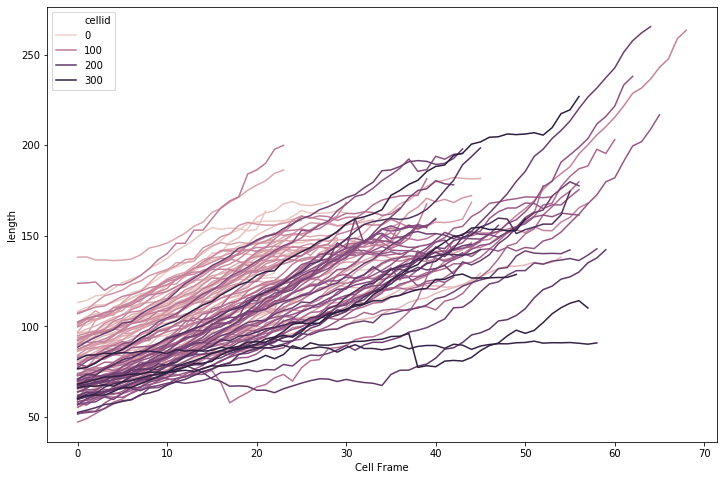

In [308]:
plt.figure(figsize=(12,8))
sns.lineplot(x='rel_frame', y='length', hue='cellid', data=sdf[sdf.track_length > 20], ci=None)
plt.xlabel('Cell Frame')
plt.savefig("Data/Figs/cell_frame_length.pdf")

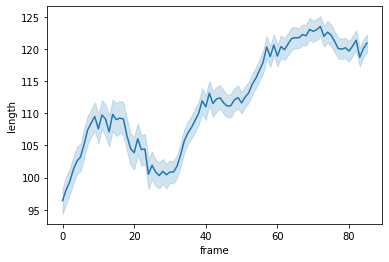

In [309]:
sns.lineplot(x='frame', y='length', data=sdf, ci=68)
plt.savefig("Data/Figs/frame_length.pdf")

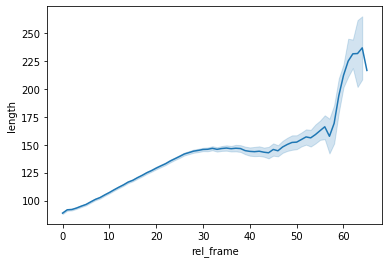

In [310]:
sns.lineplot(x='rel_frame', y='length', data=sdf[sdf.start_frame > 0], markers=True, ci=68)
plt.savefig("Data/Figs/rel_frame_length.pdf")

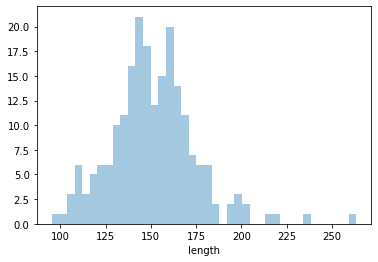

In [396]:
sns.distplot(sdf[(sdf.end_frame == sdf.rel_frame) & (sdf.last_frame < 83)& (sdf.track_length > 6)].length, bins=40, kde=False)
#sns.lineplot(x='end_frame', y='length', data=sdf)
plt.savefig("Data/Figs/length_at_end.pdf")

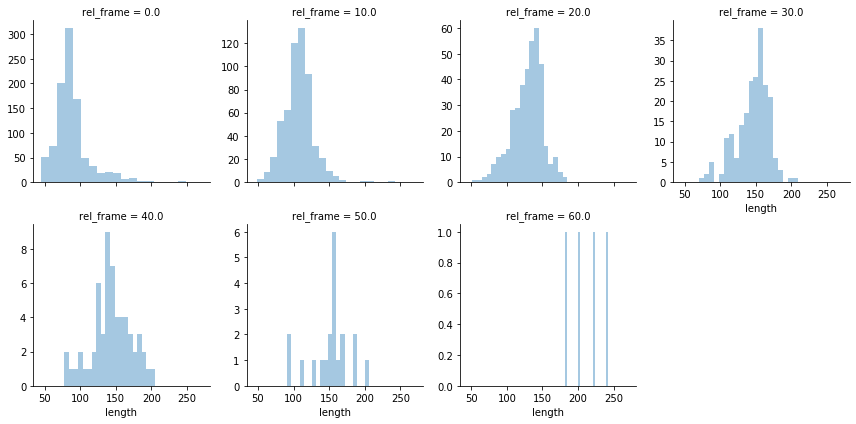

In [354]:
f = 15
# sns.distplot(sdf[(sdf.rel_frame == f) & (sdf.start_frame > 0)].length, bins=25, kde=False)
# plt.axvline(sdf[sdf.rel_frame == f].length.mean())
gsdf = sdf[sdf.start_frame > 0]
gsdf = gsdf[gsdf.rel_frame % 10 == 0]
gsdf = gsdf[gsdf.start_frame > 0]
g = sns.FacetGrid(gsdf, col='rel_frame', col_wrap=4, sharey=False)
g.map(sns.distplot, 'length', bins=20, kde=False)

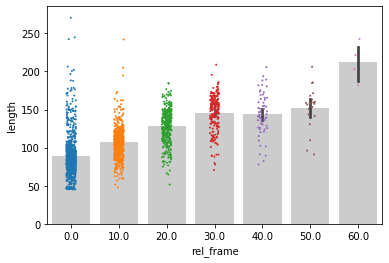

In [402]:
sns.barplot(x='rel_frame', y='length', data=gsdf, ci=95, color='#cccccc')
sns.stripplot(x='rel_frame', y='length', data=gsdf, s=2)
plt.savefig("Data/Figs/length_at_frames.pdf")

'Data/Figs/rel_frame_max.pdf'

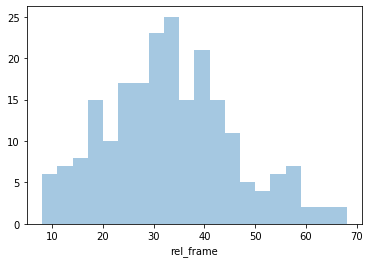

In [398]:
sns.distplot(gesdf.rel_frame, bins=20, kde=False)
"Data/Figs/rel_frame_max.pdf"

In [384]:
gesdf

cellid  index      length       xdiff      ydiff          cmx  \
0        0.0      0  133.909659  132.859871  27.598222  1949.983750   
1        1.0      0  129.487352  129.426604  29.725911   870.768322   
2        2.0      0  163.241745  161.021299  39.069906  1200.818653   
3        3.0      0  143.473029  141.197853  38.726200   782.109016   
4        4.0      0  153.243062  153.212181  29.736639  1428.587191   
...      ...    ...         ...         ...        ...          ...   
1010  1061.0      0   80.040335   77.907527  27.504347  1626.884367   
1011  1062.0      0   93.244581   93.029416  26.335599   808.373644   
1012  1063.0      0  102.877965  102.750851  27.493154  1368.847487   
1013  1064.0      0   99.392746   99.159401  25.485505  1430.558363   
1014  1065.0      0   57.745187   56.796226  25.183681  1703.468627   

              cmy  area        e0        e1  frame  label  keyed  start_frame  \
0       32.105752  2799  0.987129  0.442275     35      6   True          1.0   
1       57.423077  3046  0.758372 -0.651822     22      5   True          0.0   
2       92.573695  3981  0.762679  0.674333     17      4   True          0.0   
3       89.750313  3382  0.884411  0.535814     28     10   True          0.0   
4      116.496434  3803  0.991446  0.158486     17      6   True          0.0   
...           ...   ...       ...       ...    ...    ...    ...          ...   
1010  1572.635659  1548  0.761870 -0.647730     82    390   True         82.0   
1011  1632.972343  1844  0.750916 -0.660398     82    401   True         82.0   
1012  1811.554593  2308  0.417845 -0.908518     82    432   True         82.0   
1013  1902.187974  1979  0.664169 -0.747583     82    455   True         82.0   
1014  2023.236275  1020  0.799142 -0.601143     82    494   True         82.0   

      rel_frame  end_frame  last_frame  track_length  
0          34.0       34.0        35.0          33.0  
1          22.0       22.0        22.0          22.0  
2          17.0       17.0        17.0          17.0  
3          28.0       28.0        28.0          28.0  
4          17.0       17.0        17.0          17.0  
...         ...        ...         ...           ...  
1010        0.0        2.0        84.0         -80.0  
1011        0.0        2.0        84.0         -80.0  
1012        0.0        2.0        84.0         -80.0  
1013        0.0        2.0        84.0         -80.0  
1014        0.0        2.0        84.0         -80.0  

[1015 rows x 18 columns]

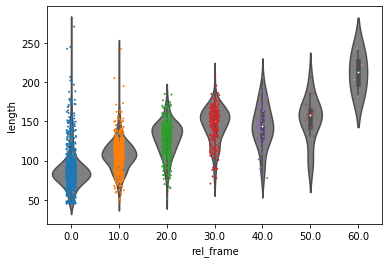

In [391]:
sns.violinplot(x='rel_frame', y='length', data=gsdf, color='gray')
sns.stripplot(x='rel_frame', y='length', data=gsdf, s=2)